<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Project Title: ClinicalNotes Diagnosis Classification Using Bert-FineTuning</b></h1>



### Tabel of Contents:



* [Import Libraries](#1)

* [Load Dataset](#2)

* [Bert Model](#4)

* [Evaluation](#3)

* [Predictive for Test](#8)

* [Like this? Upvote and comment! 🌊 End](#6)

**<a id="1"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Import Libraries</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
!pip install datasets

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset, Dataset
from transformers import BertTokenizer,BertForSequenceClassification,Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import re
import nltk
from huggingface_hub import login
import google.generativeai as genai
import os
import json
import wandb
wandb.init(mode = "disabled")
import warnings
warnings.filterwarnings('ignore')

**<a id="2"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Load Dataset</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [3]:
# Load the dataset
data = pd.read_csv("/kaggle/input/clinical-notes-diagnosis-prediction-5000/clinical_notes_diagnosis_prediction_5000.csv")
data.head()

,Clinical Notes,Diagnosis
0,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
1,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
2,A 50-year-old male with a history of diabetes ...,Septic Shock
3,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
4,A 55-year-old female with a history of obesity...,Type 2 Diabetes Mellitus


In [4]:
data.shape

(5000, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Clinical Notes  5000 non-null   object
 1   Diagnosis       5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [6]:
data.Diagnosis.value_counts()

Diagnosis
Peptic Ulcer Disease                     284
Type 2 Diabetes Mellitus                 283
Acute Myocardial Infarction              272
Chronic Obstructive Pulmonary Disease    269
Cerebrovascular Accident                 263
Deep Vein Thrombosis                     260
Community-Acquired Pneumonia             251
Chronic Kidney Disease                   251
Septic Shock                             246
Rheumatoid Arthritis                     246
Congestive Heart Failure                 245
Pulmonary Embolism                       245
Sepsis                                   241
Stroke                                   241
Liver Cirrhosis                          240
Urinary Tract Infection                  239
Acute Renal Failure                      239
Hypertension                             236
Asthma                                   235
Gastroesophageal Reflux Disease          214
Name: count, dtype: int64

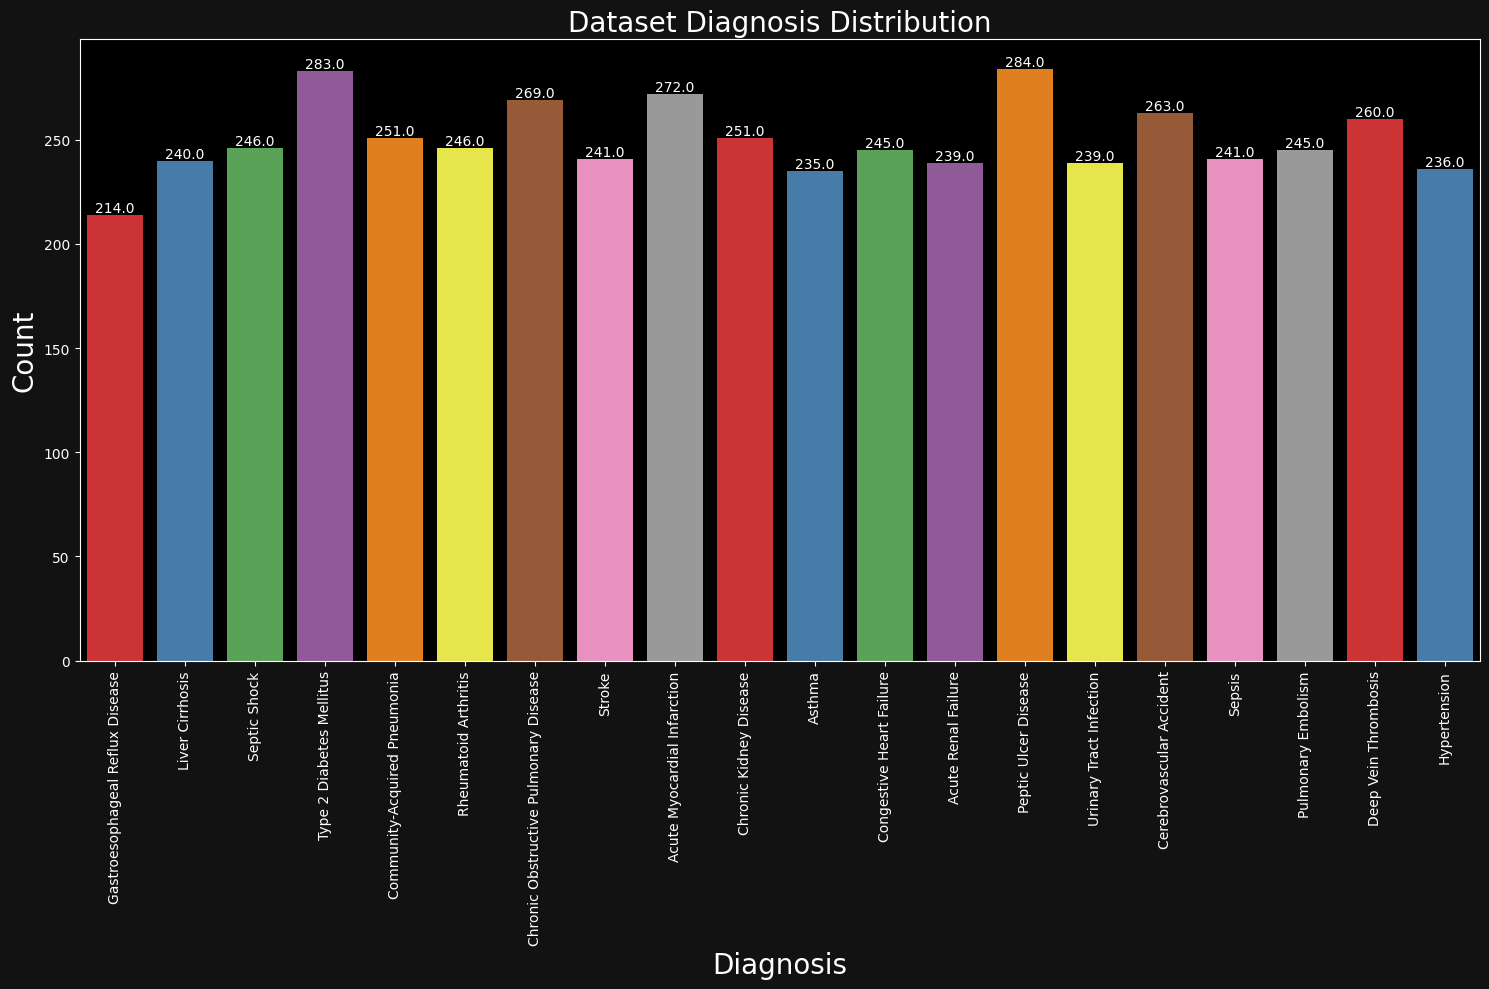

In [7]:
plt.figure(figsize=(15, 10), facecolor='#121212')
plt.style.use('dark_background')
sns.countplot(x='Diagnosis', data=data, palette="Set1")
plt.title('Dataset Diagnosis Distribution',fontsize=20)
plt.xlabel("Diagnosis",fontsize=20)
plt.ylabel("Count",fontsize=20)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='white', xytext=(0, 5),
                   textcoords='offset points')
# Rotate x-axis labels
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [8]:
# Load stopwords
stop_words = set(stopwords.words('english'))
# Extended clean_text function with more steps
def clean_text(text):
    # Convert to string and lowercase the text
    text = str(text).lower()
    # Remove any numbers (you may want to modify this if numbers are important)
    text = re.sub(r'\d+', '', text)
    # Remove special characters, punctuation, and non-alphabetical characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to the Clinical Notes column
data['Clinical Notes'] = data['Clinical Notes'].apply(clean_text)
# Show the cleaned data
data.head()

,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
1,yearold male history heavy alcohol use present...,Liver Cirrhosis
2,yearold male history diabetes presents hypoten...,Septic Shock
3,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
4,yearold female history obesity hypertension pr...,Type 2 Diabetes Mellitus


In [9]:
# Label encoding for 'diagnosis' column
label_encoder = LabelEncoder()
data['Diagnosis'] = label_encoder.fit_transform(data['Diagnosis'])
data.head()

,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,9
1,yearold male history heavy alcohol use present...,11
2,yearold male history diabetes presents hypoten...,16
3,yearold male presents heartburn regurgitation ...,9
4,yearold female history obesity hypertension pr...,18


In [10]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=True, random_state=42)
# Split the test_data into two equal halves
test_data, val_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=42)
# Print the shapes of the resulting datasets
print("Shape of train_data:", train_data.shape)
print("Shape of test_data1:", test_data.shape)
print("Shape of test_data2:", val_data.shape)

Shape of train_data: (3500, 2)
Shape of test_data1: (750, 2)
Shape of test_data2: (750, 2)


In [11]:
train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)
val_dataset = Dataset.from_dict(val_data)
train_dataset

Dataset({
    features: ['Clinical Notes', 'Diagnosis'],
    num_rows: 3500
})

<a id="4"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Bert Model</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [12]:
# Initialize tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=len(label_encoder.classes_))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
len(label_encoder.classes_)

20

In [14]:
max_length = max([len(tokenizer.encode(text)) for text in train_dataset['Clinical Notes']])
max_length

65

In [15]:
# Tokenization function
def tokenize_function(examples):
    # Tokenize sentence1 and sentence2
    model_inputs = tokenizer(examples['Clinical Notes'], max_length=512 ,truncation=True, padding="max_length")
    model_inputs['labels'] = examples['Diagnosis']
    return model_inputs
# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
print(train_dataset[0])

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

{'Clinical Notes': 'yearold male history atrial fibrillation presents sudden onset dizziness leftsided weakness patients wife reports brief loss consciousness ct scan reveals intracerebral hemorrhage right parietal lobe patient managed conservatively blood pressure control neurosurgical consultation', 'Diagnosis': 3, 'input_ids': [101, 2095, 11614, 3287, 2381, 2012, 14482, 10882, 23736, 20382, 7534, 5573, 14447, 4487, 29212, 2187, 7363, 2094, 11251, 5022, 2564, 4311, 4766, 3279, 8298, 14931, 13594, 7657, 26721, 17119, 15878, 7941, 19610, 2953, 25032, 4270, 2157, 11968, 2666, 9080, 21833, 5776, 3266, 4603, 2135, 2668, 3778, 2491, 11265, 10976, 26210, 26715, 16053, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
# Define a metric computation function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}
# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./Finetuning_Bert_ClinicalNotes_Diagnosis_Classification",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)
# Define Trainer with metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [17]:
trainer.train()
trainer.save_model()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.022168,1.000000,1.000000
2,0.652600,0.006815,1.000000,1.000000
3,0.013200,0.004020,1.000000,1.000000
4,0.006100,0.003045,1.000000,1.000000
5,0.004300,0.002758,1.000000,1.000000


In [18]:
tokenizer.save_pretrained(training_args.output_dir)

('./Finetuning_Bert_ClinicalNotes_Diagnosis_Classification/tokenizer_config.json',
 './Finetuning_Bert_ClinicalNotes_Diagnosis_Classification/special_tokens_map.json',
 './Finetuning_Bert_ClinicalNotes_Diagnosis_Classification/vocab.txt',
 './Finetuning_Bert_ClinicalNotes_Diagnosis_Classification/added_tokens.json')

In [ ]:
login(token="HUGGINGFACE_TOKEN")

In [23]:
repo_name = "ahmed792002/Finetuning_Bert_ClinicalNotes_Diagnosis_Classification"
trainer.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

events.out.tfevents.1733950884.fadb5ce41a76.23.0:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/ahmed792002/Finetuning_Bert_ClinicalNotes_Diagnosis_Classification/commit/f00ab3b6243b4b5e73830aebd00254034d933816', commit_message='Upload tokenizer', commit_description='', oid='f00ab3b6243b4b5e73830aebd00254034d933816', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ahmed792002/Finetuning_Bert_ClinicalNotes_Diagnosis_Classification', endpoint='https://huggingface.co', repo_type='model', repo_id='ahmed792002/Finetuning_Bert_ClinicalNotes_Diagnosis_Classification'), pr_revision=None, pr_num=None)

**<a id="1"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Evaluation</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [24]:
results = trainer.evaluate(test_dataset)
print("Evaluation results:")
print("Test Loss = ",results["eval_loss"])
print("Test Accuracy = ",results["eval_accuracy"])
print("Test F1 Score = ",results["eval_f1"])

Evaluation results:
Test Loss =  0.0027596703730523586
Test Accuracy =  1.0
Test F1 Score =  1.0


In [25]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
predicted_labels

array([ 9, 12,  3,  6,  2,  1,  0, 15, 14, 18,  0, 17,  0, 19,  3,  7,  7,
       17, 10,  7, 11,  2, 18, 13, 12,  4,  8, 15,  6, 10, 10, 14,  3, 19,
       17, 18,  8,  0, 19, 18, 19, 13,  0, 15, 18, 19,  1,  0,  4,  9, 16,
       10,  7,  0,  7,  8, 11,  6,  5, 12, 12, 16,  1,  0,  0,  5, 15,  4,
       10,  1,  3,  0, 16,  8,  7,  6, 14, 10,  9, 18,  7,  0, 19,  4, 17,
       15,  9,  8, 18,  9,  2,  3,  4,  1, 13,  8, 16, 16,  3, 18,  2,  4,
       12, 13, 19, 15,  8, 14,  5, 13,  2, 10, 12, 11,  9,  7,  2,  7,  4,
       16,  6, 14,  3, 12, 17, 18,  9, 10, 17, 10, 17, 16,  9, 16,  6,  8,
       17, 13, 16,  1, 18,  5,  5, 12,  4, 15,  4,  6, 14,  7,  8,  0, 11,
        7, 17,  3, 14, 11,  6, 16,  0, 19,  7, 14, 10, 15,  5,  1, 16,  0,
        6,  8, 13, 18,  4, 14,  9, 17, 18, 12,  7, 15,  2, 13, 17, 15, 14,
        9,  1, 16,  2,  4,  0,  4,  1,  5, 15, 12,  3,  7, 14, 18, 17,  2,
        2, 12,  3, 17, 15, 19,  4, 14, 16,  1,  6,  6, 12, 13,  8, 14, 18,
       10, 18, 14, 10, 12

In [26]:
# Make sure the 'label_encoder.classes_' are passed as string labels
target_names = [str(label) for label in label_encoder.classes_]
target_names

['Acute Myocardial Infarction',
 'Acute Renal Failure',
 'Asthma',
 'Cerebrovascular Accident',
 'Chronic Kidney Disease',
 'Chronic Obstructive Pulmonary Disease',
 'Community-Acquired Pneumonia',
 'Congestive Heart Failure',
 'Deep Vein Thrombosis',
 'Gastroesophageal Reflux Disease',
 'Hypertension',
 'Liver Cirrhosis',
 'Peptic Ulcer Disease',
 'Pulmonary Embolism',
 'Rheumatoid Arthritis',
 'Sepsis',
 'Septic Shock',
 'Stroke',
 'Type 2 Diabetes Mellitus',
 'Urinary Tract Infection']

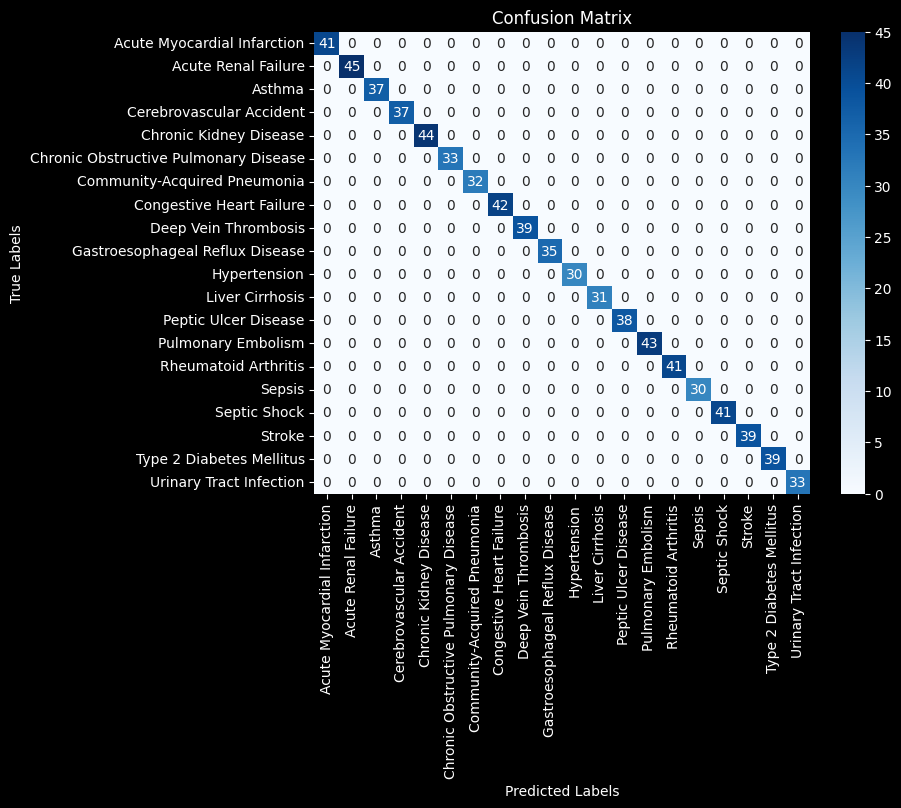

In [27]:
# Compute the confusion matrix
true_labels = test_dataset["labels"]
cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [29]:
# Print the classification report
print("Classification Report :\n",classification_report(true_labels, predicted_labels, target_names=target_names))

Classification Report :
                                        precision    recall  f1-score   support

          Acute Myocardial Infarction       1.00      1.00      1.00        41
                  Acute Renal Failure       1.00      1.00      1.00        45
                               Asthma       1.00      1.00      1.00        37
             Cerebrovascular Accident       1.00      1.00      1.00        37
               Chronic Kidney Disease       1.00      1.00      1.00        44
Chronic Obstructive Pulmonary Disease       1.00      1.00      1.00        33
         Community-Acquired Pneumonia       1.00      1.00      1.00        32
             Congestive Heart Failure       1.00      1.00      1.00        42
                 Deep Vein Thrombosis       1.00      1.00      1.00        39
      Gastroesophageal Reflux Disease       1.00      1.00      1.00        35
                         Hypertension       1.00      1.00      1.00        30
                      Live

<a id="8"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Predictive for Test</p></b></h1>

In [30]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ahmed792002/Finetuning_Bert_ClinicalNotes_Diagnosis_Classification")
model = AutoModelForSequenceClassification.from_pretrained("ahmed792002/Finetuning_Bert_ClinicalNotes_Diagnosis_Classification")

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [42]:
config_data = json.load(open("/kaggle/input/gemini-api/config.json"))
GOOGLE_API_KEY = config_data["GOOGLE_API_KEY"]
genai.configure(api_key=GOOGLE_API_KEY)

In [70]:
def Details(predicted_disease):
    # Construct the prompt for the AI model for 
    model = genai.GenerativeModel("gemini-1.5-pro")
    prompt = f"""
    You are an AI assistant helping the user generate description , medicines , 
    specialists for {predicted_disease}
    Please generate in the form.
    Format:
    {"*"*50}
    Description :
    description
    {"*"*50}
    Medicines :
    medicine1, medicine2, medicine3, ...
    {"*"*50}
    Specialists :
    specialist1, specialist2, specialist3, ...
    {"*"*50}
    """
    flag = True
    while flag:
        try:
            # Generate response using the model
            response = model.generate_content(prompt).text.strip()
            # Format the response for better readability (optional)
            formatted_response = response.replace('\n', '\n\n')
            print(formatted_response)
            flag = False
        except:
            pass

In [71]:
# Function to make prediction
def predict_disease(patient_note,label=-1):
    # Tokenize the input patient note
    inputs = tokenizer(patient_note, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    # Get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()
    # Convert the predicted label to the corresponding disease name
    predicted_disease = label_encoder.inverse_transform([predicted_label])[0]
    print("Patient Note : \n",patient_note)
    print("\n","*"*50,"\n")
    if label != -1:
      print("Actual Output : ",label_encoder.inverse_transform([label])[0])
    print("Output : ",predicted_disease)
    Details(predicted_disease)

In [72]:
text , label = test_dataset["Clinical Notes"][100],test_dataset["Diagnosis"][100]
predict_disease(text,label)

Patient Note : 
 yearold male presents recurrent episodes wheezing shortness breath particularly night exercise patient history childhood asthma asymptomatic several years spirometry shows reduced fevfvc ratio patient diagnosed asthma prescribed combination inhaled corticosteroids bronchodilator

 ************************************************** 

Actual Output :  Asthma
Output :  Asthma
**************************************************

Description :

Asthma is a chronic lung disease that inflames and narrows the airways.  Symptoms include wheezing, coughing, chest tightness, and shortness of breath.  These symptoms can range from mild to severe and can be triggered by various factors like allergens (e.g., pollen, dust mites, pet dander), irritants (e.g., smoke, fumes), respiratory infections, exercise, and stress.  Asthma is a long-term condition that requires ongoing management to control symptoms and prevent exacerbations (asthma attacks).

**************************************

In [73]:
text , label = test_dataset["Clinical Notes"][200],test_dataset["Diagnosis"][200]
predict_disease(text,label)

Patient Note : 
 yearold female presents joint pain particularly hands wrists worsening past months patient morning stiffness lasting minutes rheumatoid factor anticcp antibodies elevated patient started diseasemodifying antirheumatic drugs dmards rheumatoid arthritis

 ************************************************** 

Actual Output :  Rheumatoid Arthritis
Output :  Rheumatoid Arthritis
**************************************************

Description :

Rheumatoid arthritis (RA) is a chronic autoimmune inflammatory disease that primarily affects the joints. It typically causes warm, swollen, and painful joints. Most commonly, the small joints of the hands and feet are affected.  Over time, the inflammation can cause damage to cartilage and bone, leading to joint deformity and disability. RA can also affect other parts of the body, such as the lungs, heart, and eyes. The exact cause of RA is unknown, but it's thought to involve a combination of genetic and environmental factors.  Symp

In [74]:
text , label = test_dataset["Clinical Notes"][500],test_dataset["Diagnosis"][500]
predict_disease(text,label)

Patient Note : 
 yearold female presents epigastric pain worsens meals patient history frequent use nsaids chronic back pain upper endoscopy reveals gastric ulcer patient started proton pump inhibitors advised avoid nsaids

 ************************************************** 

Actual Output :  Peptic Ulcer Disease
Output :  Peptic Ulcer Disease
**************************************************

Description :

Peptic ulcer disease (PUD) is a condition in which painful sores or ulcers develop in the lining of the stomach or the first part of the small intestine (duodenum).  The most common causes are infection with the bacterium Helicobacter pylori (H. pylori) and long-term use of nonsteroidal anti-inflammatory drugs (NSAIDs) such as ibuprofen and aspirin.  Symptoms include burning stomach pain, feeling full quickly after eating, bloating, burping, nausea, and sometimes vomiting.  Complications can include bleeding, perforation, and blockage of the digestive tract.

********************

<center><span style="font-family:Palatino; font-size:22px;"><i>Like this? <span style="color:#DC143C;">Upvote and Comment!</span> </i>🌊 End</span> </center>